In [1]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple, defaultdict

from robustness import logger
logger.setLevel('INFO')

from robustness import NETWORKS_DIR
from robustness.mpl_settings_v3 import *
from robustness.planar import create_proximity_graph
from robustness.auxiliary import (
    getLinearReg, 
    get_base_network_name, 
    powerlaw, 
    load_delta_data, 
    read_data_file
)
from robustness.plot_auxiliary import (
    letters,
    attack_dict,
    fig_dir, 
    load_delta,
    load_deltas,
    load_dataframe, 
    get_critical_measures,
    getPeaks,
    compute_fc_v2,
    get_rc_values,
    get_l_cutoff
)

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

marker_dict = {'meanS': 'o', 'Nsec': 's', 'varSgcc': '^', 'Sgcc': '*', 'num_over_denom': '>'}
color_dict = {'meanS': 'C0', 'Nsec': 'C1', 'varSgcc': 'C2', 'Sgcc': 'C3', 'num_over_denom': 'C4'}
linestyle_dict = {'meanS': '--', 'Nsec': '-.', 'varSgcc': ':', 'Sgcc': ':', 'num_over_denom': '--'}
measures_dict = {
    'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 N$', 'varSgcc': r'$\chi$',
    'Sgcc': r'$N_1$', 'num_over_denom': r'$\langle s \rangle_{\mathrm{ens}}$'
}
line_colors = {'meanS': 'k', 'Nsec': 'grey', 'varSgcc': 'brown', 'Sgcc': 'C8', 'num_over_denom': 'C7'}

In [30]:
def fit_lstar(l_cutoffs, keep_last=None):
    
    aux = {size: v for size, v in l_cutoffs.items() if ~np.isnan(v)}

    X = np.sqrt(list(aux.keys()))
    Y = np.array(list(aux.values()))
    if keep_last:
        X = X[-keep_last:]
        Y = Y[-keep_last:]
    Y_pred, slope, y_err = getLinearReg(X, Y)

    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(X, Y, 'o')
    label = r'${{{:.2f}}}\pm {{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color='k', label=label)
    ax.legend()
    plt.show()

def rc_dict_to_arrays(rc_values_dict, rc_values_std_dict, lmax=200, base_attack='Btw', sizes=None):
    
    if not sizes:
        sizes = rc_values_dict.keys()

    l_values = np.arange(1, lmax+1)
    
    rc_values = {
        size: np.array([rc_values_dict[size][base_attack]] + [np.nan]*lmax)
        for size in sizes
    }
    rc_values_std = {
        size: np.array([rc_values_std_dict[size][base_attack]] + [np.nan]*lmax) 
        for size in sizes
    }
    for size in sizes:
        for l in l_values:
            attack = f'{base_attack}_cutoff{l}'
            if attack in rc_values_dict[size]:
                rc_values[size][l] = rc_values_dict[size][attack]
                rc_values_std[size][l] = rc_values_std_dict[size][attack]
                
    return rc_values, rc_values_std, l_values

In [35]:
base_attack = 'Btw'
net_type = 'DT'
param = 'param'
min_nseeds = 1000
nseeds = None
threshold = 0.001
sizes = [
    1024, 2048, 4096, 
    8192, 16384, 32768, 65536, 131072
]

max_rc_values_dict, max_rc_values_std_dict = get_rc_values(
    net_type, param, base_attack, sizes, 
    nseeds=nseeds, min_nseeds=min_nseeds
)
l_cutoff = get_l_cutoff(
    net_type, param,  base_attack, sizes, 
    threshold=threshold,
    nseeds=nseeds, min_nseeds=min_nseeds
)
l_cutoff

{1024: 19,
 2048: 25,
 4096: 32,
 8192: 44,
 16384: 60,
 32768: 82,
 65536: nan,
 131072: nan}

In [36]:
all_rc_values = {}
nseeds_values = [100, 1000, 10000]
for nseeds in nseeds_values:
    rc_values, rc_values_std = get_rc_values(
        net_type, param, base_attack, sizes, 
        nseeds=nseeds, min_nseeds=min_nseeds
    )   
    all_rc_values[nseeds] = rc_values, rc_values_std

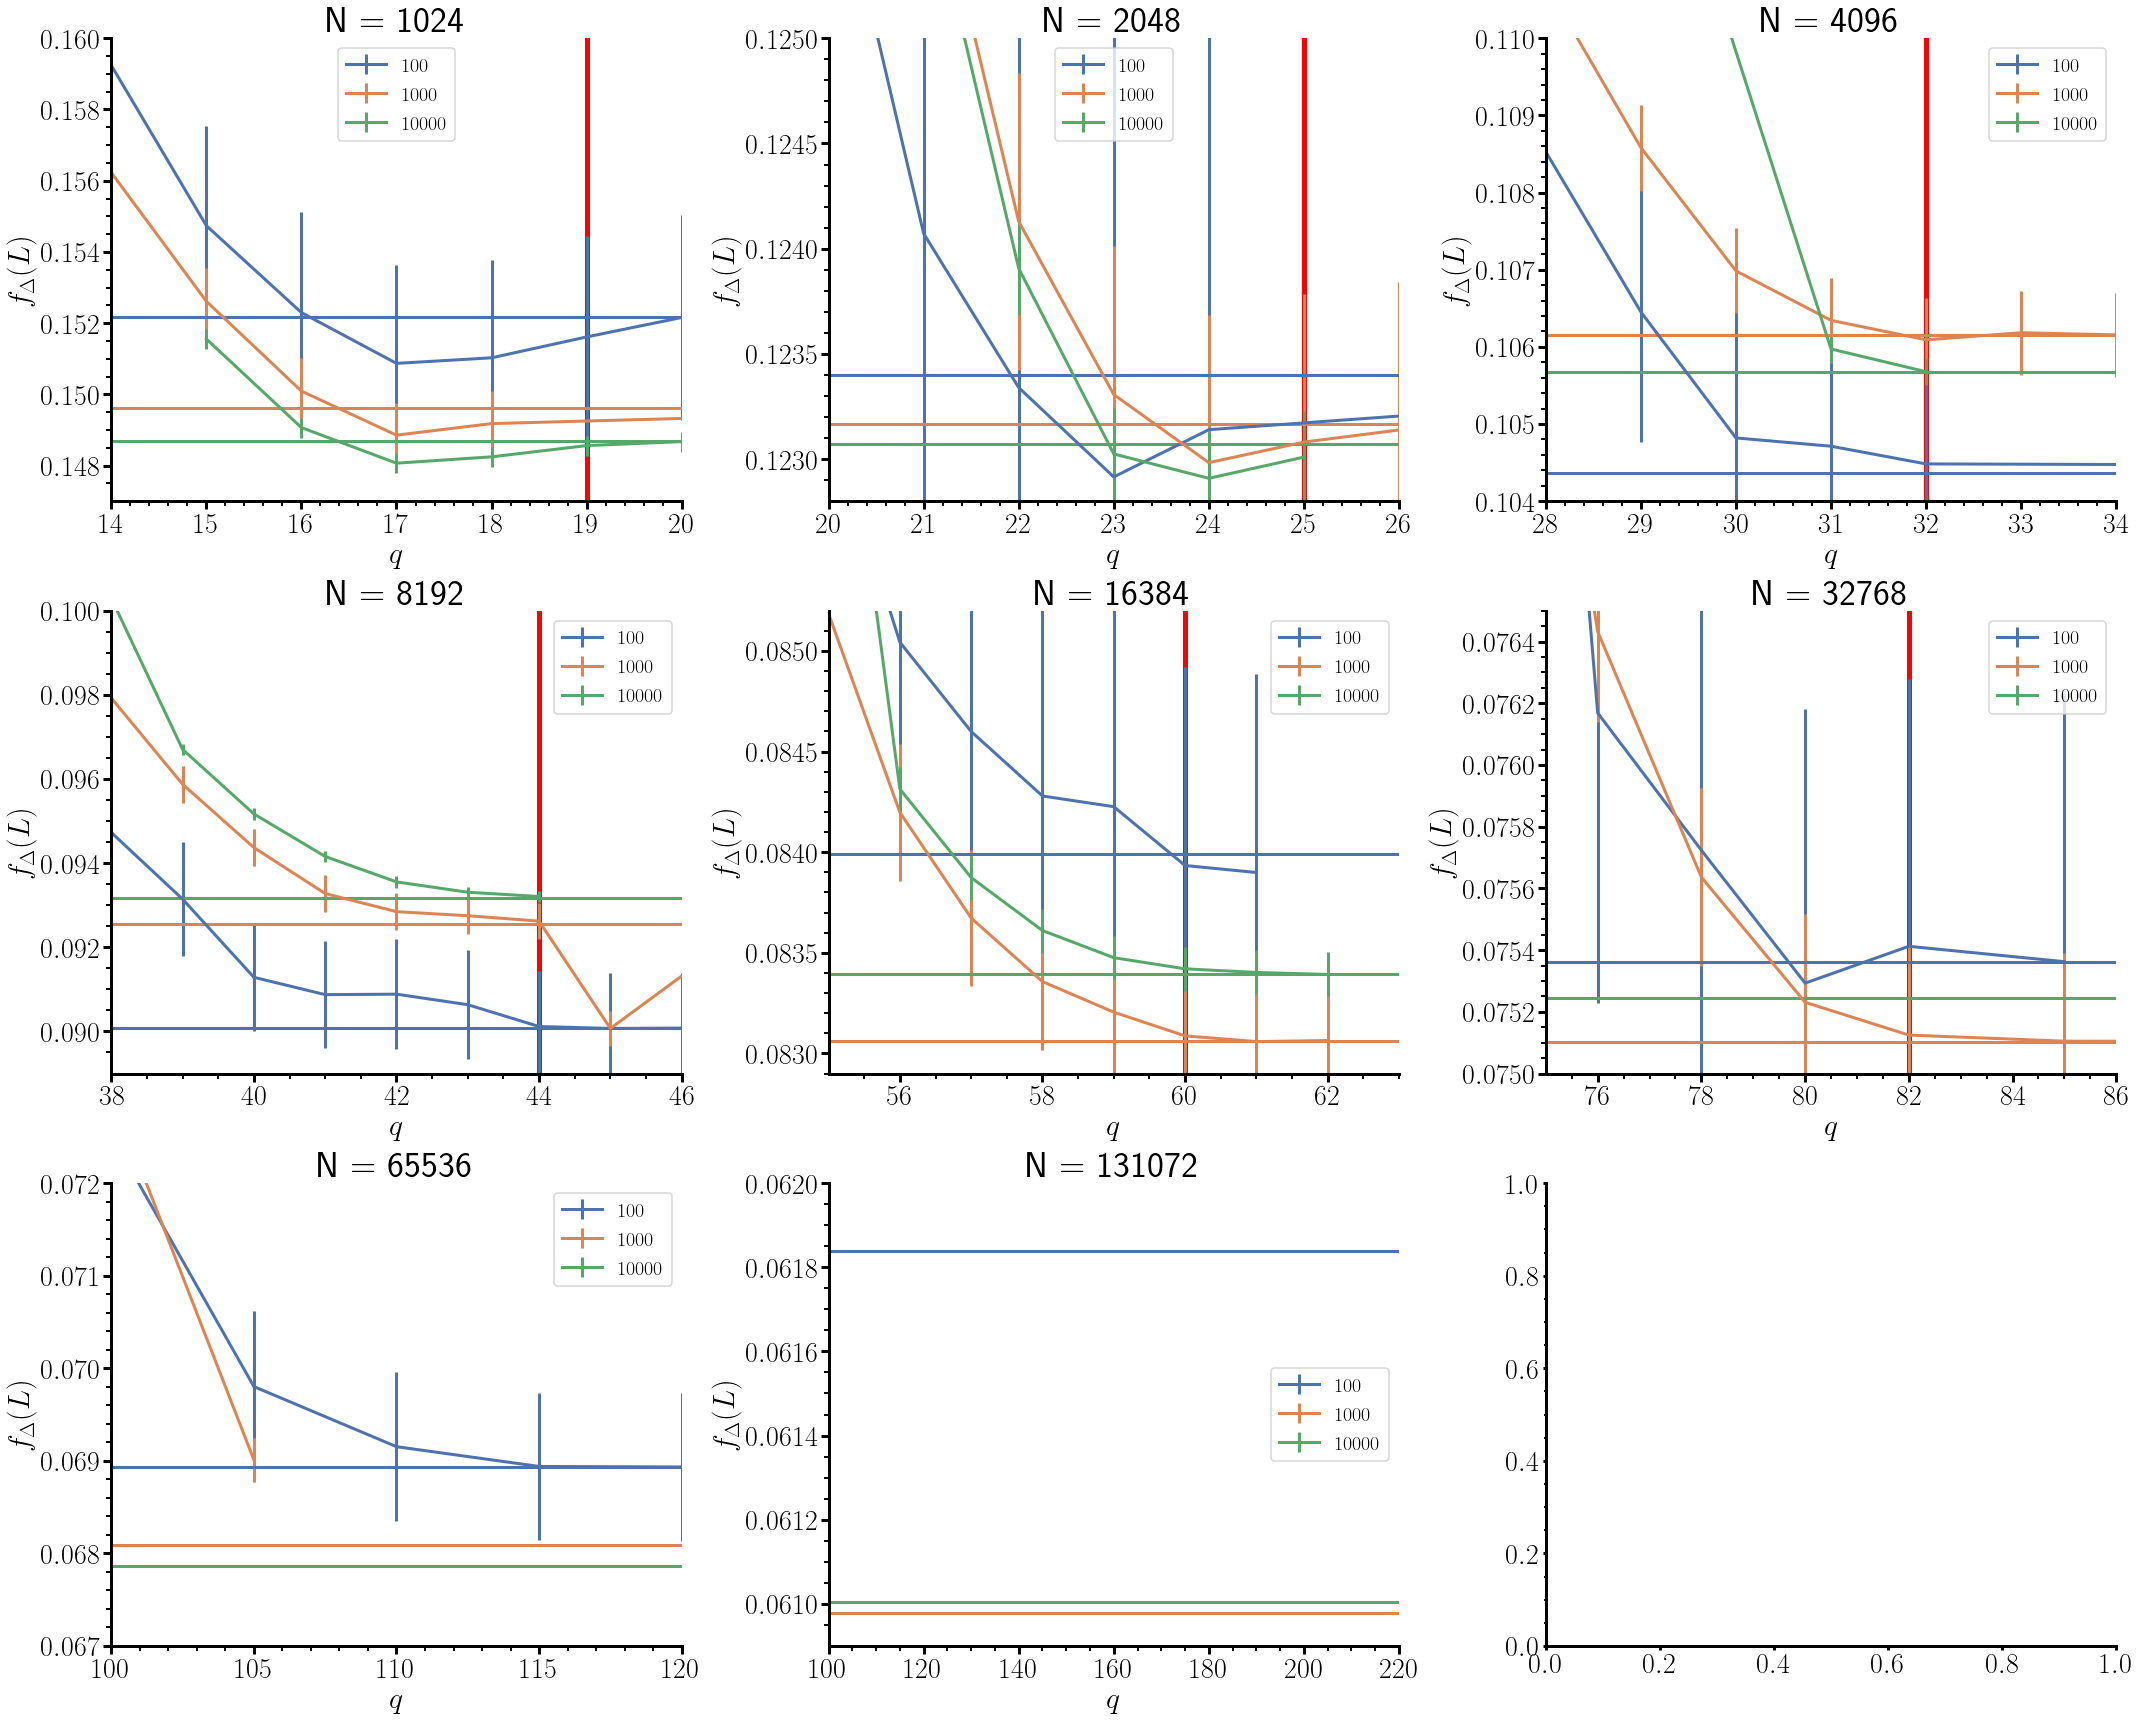

In [39]:
Params = namedtuple('Params', ['xlim', 'ylim'])

def plot_cutoff(all_rc_values, size, ax):
    ax = axes[i]
    xlim, ylim = params[size]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'$q$')
    ax.set_ylabel(r'$f_{\Delta}(L)$')
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    
    ax.set_title(f'N = {size}', fontsize=36)
    L = np.sqrt(size)
    for j, (nseeds, (rc_values_dict, rc_values_std_dict)) in enumerate(all_rc_values.items()):
        
        rc_values, rc_values_std, l_values = rc_dict_to_arrays(rc_values_dict, rc_values_std_dict)

        mask = ~np.isnan(rc_values[size][1:])

        X = l_values[mask]
        Y = rc_values[size][1:][mask] 
        Yerr = rc_values_std[size][1:][mask] / np.sqrt(nseeds)
        label = r'${{{}}}$'.format(nseeds)
        #ax.plot(X, Y, '--' + markers[i], label=label)
        ax.errorbar(X, Y, Yerr, label=label)
        ax.axhline(rc_values[size][0], color=f'C{j}')
        ax.axvline(l_cutoff[size], color='red', zorder=-100, linewidth=5)

params = {
    1024:   Params( ( 14, 20), (0.1470, 0.1600) ),
    2048:   Params( ( 20, 26), (0.1228, 0.1250) ),
    4096:   Params( ( 28, 34), (0.1040, 0.1100) ),
    8192:   Params( ( 38, 46), (0.0890, 0.1000) ),
    16384:  Params( ( 55, 63), (0.0829, 0.0852) ),
    32768:  Params( ( 75, 86), (0.0750, 0.0765) ),
    65536:  Params( (100,120), (0.0670, 0.0720) ),
    131072: Params( (100,220), (0.0609, 0.0620) )
}
sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
ncols = 3
nrows = 3
fig, axes = plt.subplots(figsize=(10*ncols,8*nrows), ncols=ncols, nrows=nrows)
axes = np.array(axes).flatten()
        
for i, size in enumerate(sizes): 
    ax = axes[i]
    plot_cutoff(all_rc_values, size, ax)
    ax.legend(loc='best', fontsize=20)

sns.despine()
plt.tight_layout()
plt.show()

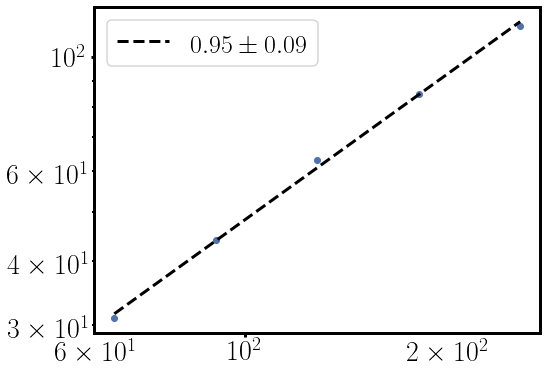

In [85]:
l_cutoff_manual = {
    4096: 31,
    8192: 44,
    16384: 63,
    32768: 85,
    65536: 115,
    131072: np.nan
}    
fit_lstar(l_cutoff_manual)

NameError: name 'max_rc_values_dict' is not defined

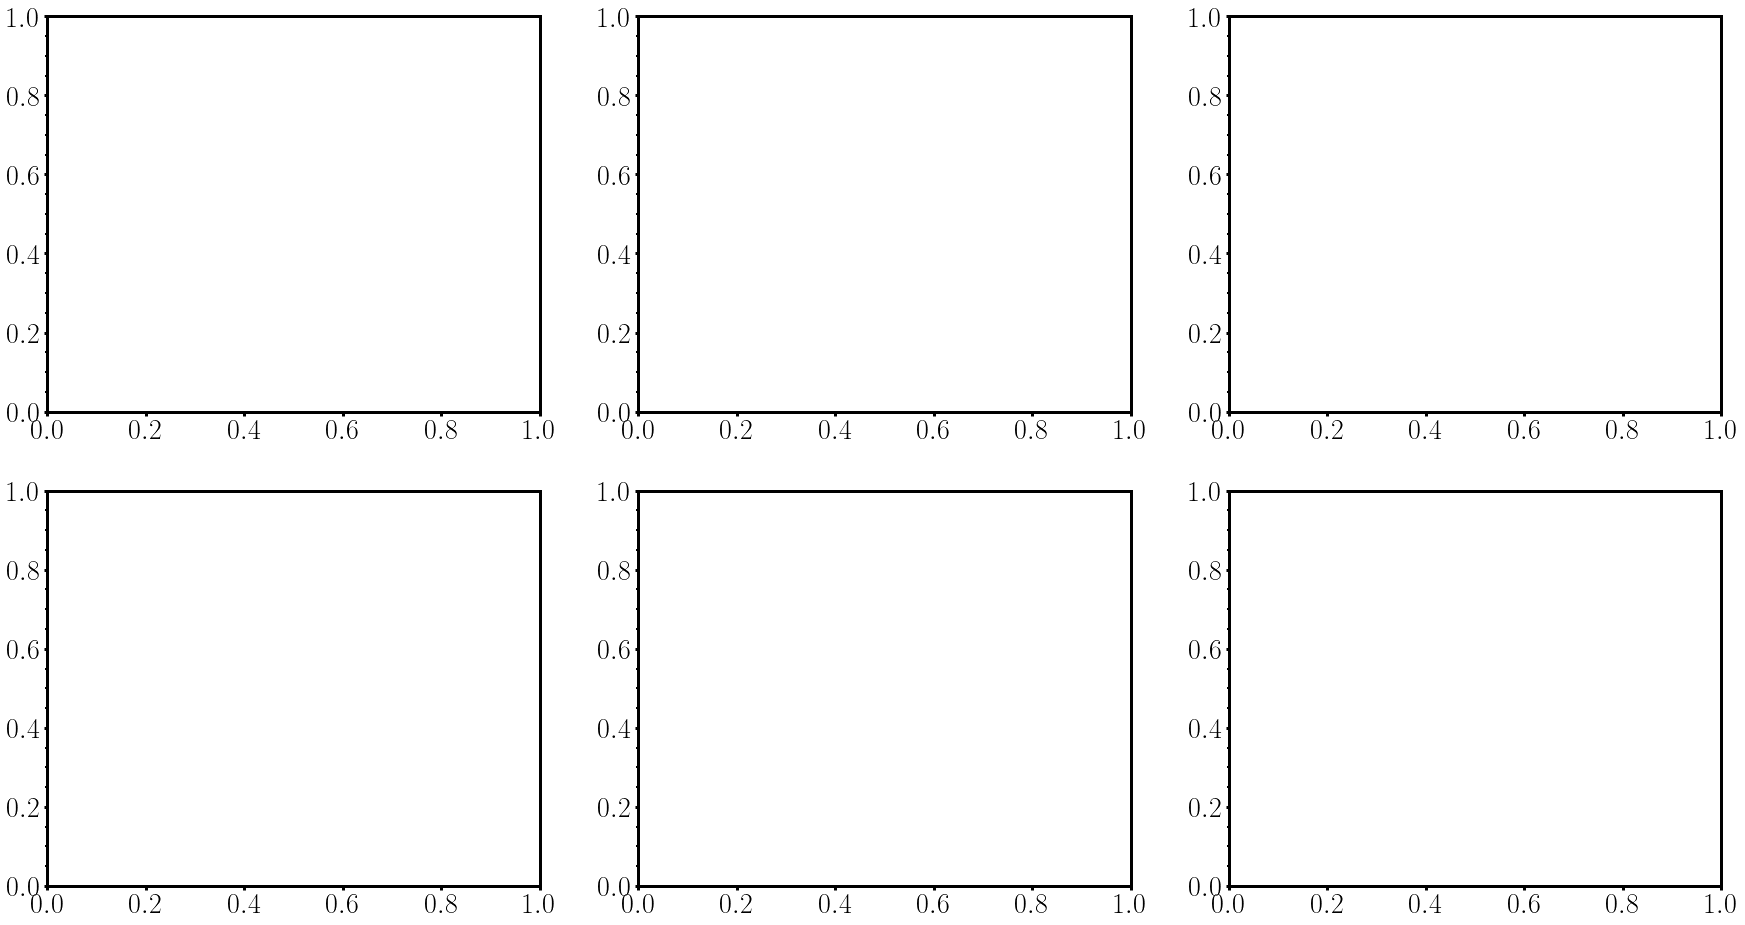

In [14]:
sizes = [1024, 2048, 4096, 8192, 16384, 32768]
ncols = 3
nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols,8*nrows), ncols=ncols, nrows=nrows)
axes = np.array(axes)
axes = axes.flatten()

def plot_cutoff(rc_values_dict, size, ax):
    ax = axes[i]
    xlim, ylim = params[size]
    ylim = (ylim[0]-1.01*ylim[0], ylim[1]-ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(-0.01, 0.04)
    ax.set_xlabel(r'$q$')
    ax.set_ylabel(r'$f_{\Delta}(L)$')
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    
    ax.set_title(f'N = {size}', fontsize=36)
    L = np.sqrt(size)
    for j, (nseeds, rc_values) in enumerate(rc_values_dict.items()):
        mask = ~np.isnan(rc_values[size][1:])

        X = l_values[mask]
        Y = (rc_values[size][1:][mask] - rc_values[size][0]) / rc_values[size][0]
        ax.plot(X, Y, '--' + markers[i], label=r'${{{}}}$'.format(nseeds))
        ax.axvline(l_cutoff[size], color='red', zorder=-100)
        ax.axhline(0, color='gray', zorder=-200)

for i, size in enumerate(sizes): 
    plot_cutoff(rc_values, size, ax)
    ax.legend(loc='best', fontsize=20)

sns.despine()
plt.tight_layout()
plt.show()

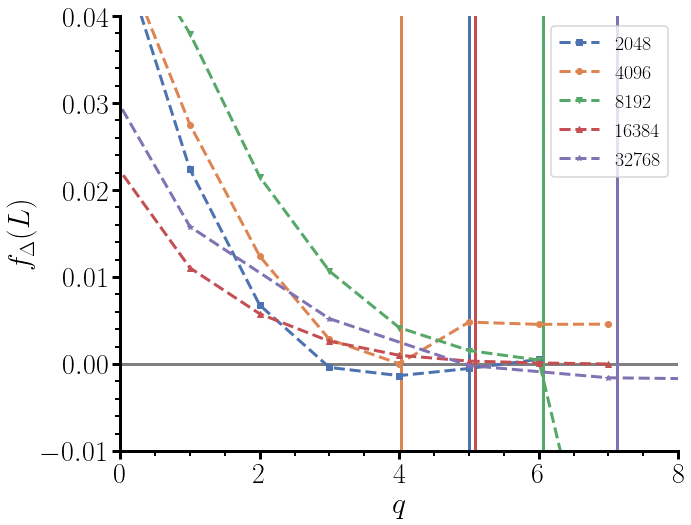

In [29]:
sizes = [2048, 4096, 8192, 16384, 32768]

max_rc_values, max_rc_values_std, l_values = rc_dict_to_arrays(max_rc_values_dict, max_rc_values_std_dict)

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols,8*nrows), ncols=ncols, nrows=nrows)
ax.set_xlim(0, 8)
ax.set_ylim(-0.01, 0.04)    
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$f_{\Delta}(L)$')
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
for i, size in enumerate(sizes): 
    (xmin, xmax), (ymin, ymax) = params[size]
    mask = ~np.isnan(max_rc_values[size][1:])
    X = l_values[mask] - xmin
    Y = (max_rc_values[size][1:][mask] - max_rc_values[size][0]) / max_rc_values[size][0]
    ax.plot(X, Y, '--' + markers[i], label=r'${{{}}}$'.format(size))
    ax.axvline(l_cutoff[size] - xmin + 0.03*i, color=f'C{i}', zorder=-100)
    ax.axhline(0, color='gray', zorder=-200)
ax.legend(loc='best', fontsize=20)
sns.despine()
plt.show()

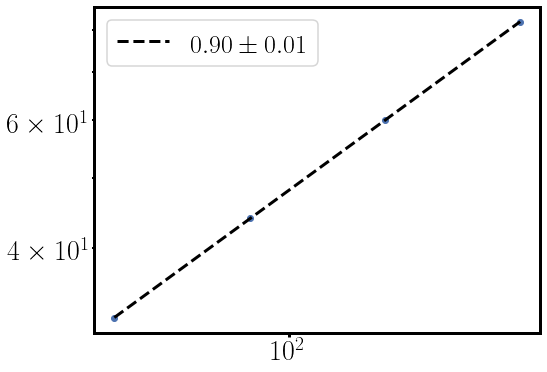

In [32]:
fit_lstar(l_cutoff, keep_last=4)